In [3]:
from src.ml.word2vec import SkipGramDataset, SkipGramModel
from torch.utils.data import DataLoader, random_split
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

import tqdm
import torch
import torch.nn as nn

[nltk_data] Downloading package punkt to /Users/jon/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
input_data = open("data/text8", "r").read()
corpus = word_tokenize(input_data.lower())[:10000]
word_to_idx = {}
idx_to_word = {}
idx = 0
for i, word in enumerate(corpus):
    if word not in word_to_idx:
        word_to_idx[word] = idx
        idx_to_word[idx] = word
        idx+=1
vocab_size = len(word_to_idx)

In [5]:
print(vocab_size, len(corpus))

2519 10000


In [8]:
mps_device = None

In [9]:
window_size = 4

In [10]:
dataset = SkipGramDataset(corpus, vocab_size, word_to_idx, idx_to_word, window_size=window_size, device=mps_device)
train_set, test_set = random_split(dataset, [0.9, 0.1])
train_loader = DataLoader(train_set, batch_size=64)
test_loader = DataLoader(test_set, batch_size=64)

In [11]:
model = SkipGramModel(vocab_size, hidden_size=300)
model.to(mps_device)

SkipGramModel(
  (embeddings): Embedding(2519, 300)
  (layer2): Linear(in_features=300, out_features=2519, bias=True)
)

In [12]:
def get_skip_grams(word, model, window_size, word_to_idx, idx_to_word, device = None):
    idx = word_to_idx[word]
    idx = torch.tensor([idx], dtype=torch.long)
    with torch.no_grad():
        output = model(idx)
    _, topi = output[0].topk(2 * window_size)
    topi = topi.squeeze(0).tolist()
    return [idx_to_word[i] for i in topi]

def get_words_sim(model, word1, word2, word_to_idx):
    idx1 = torch.LongTensor([word_to_idx[word1]])
    idx2 = torch.LongTensor([word_to_idx[word2]])
    embeddings1 = model.get_embedding(idx1)
    embeddings2 = model.get_embedding(idx2)
    return cos(embeddings1[0], embeddings2[0])

cos = torch.nn.CosineSimilarity(dim=0)


In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_losses = []
epochs = 200
for e in range(epochs):

    train_loss = 0
    for batch in tqdm.tqdm(train_loader, f"Training model {e}/{epochs}"):
        center_word, context_words = batch
        model.zero_grad()
        output = model(center_word)
        loss = criterion(output, context_words)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            center_word, context_words = batch
            outputs = model(center_word)
            loss = criterion(outputs, context_words)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f"Training loss: {train_loss}")
    print(f"Test loss: {test_loss}")


Training model 0/200: 100%|██████████| 1125/1125 [00:05<00:00, 191.95it/s]


Training loss: 7.656640350341797
Test loss: 7.423969898223877


Training model 1/200: 100%|██████████| 1125/1125 [00:05<00:00, 189.74it/s]


Training loss: 7.109109141879611
Test loss: 6.942474155426026


Training model 2/200: 100%|██████████| 1125/1125 [00:06<00:00, 184.09it/s]


Training loss: 6.756559818691677
Test loss: 6.752018127441406


Training model 3/200: 100%|██████████| 1125/1125 [00:06<00:00, 183.75it/s]


Training loss: 6.595227291107178
Test loss: 6.649937751770019


Training model 4/200: 100%|██████████| 1125/1125 [00:06<00:00, 187.24it/s]


Training loss: 6.49699949476454
Test loss: 6.586346630096435


Training model 5/200: 100%|██████████| 1125/1125 [00:06<00:00, 173.04it/s]


Training loss: 6.42921906958686
Test loss: 6.544071887969971


Training model 6/200: 100%|██████████| 1125/1125 [00:05<00:00, 189.39it/s]


Training loss: 6.378853241390652
Test loss: 6.514557098388672


Training model 7/200: 100%|██████████| 1125/1125 [00:05<00:00, 198.30it/s]


Training loss: 6.339018207126194
Test loss: 6.4930038871765134


Training model 8/200: 100%|██████████| 1125/1125 [00:05<00:00, 199.24it/s]


Training loss: 6.305780092027452
Test loss: 6.476633159637451


Training model 9/200: 100%|██████████| 1125/1125 [00:05<00:00, 191.72it/s]


Training loss: 6.276805559794108
Test loss: 6.463774024963379


Training model 10/200: 100%|██████████| 1125/1125 [00:05<00:00, 197.41it/s]


Training loss: 6.250593652513292
Test loss: 6.453289501190185


Training model 11/200:  59%|█████▉    | 666/1125 [00:03<00:02, 195.73it/s]


KeyboardInterrupt: 

In [ ]:
get_skip_grams("revolution", model, window_size, word_to_idx, idx_to_word, device=mps_device)

['the', 'of', 'in', 'one', 'and', 'nine', 'to', 'a']

In [ ]:
corpus[:100]

['',
 'anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english',
 'revolution',
 'and',
 'the',
 'sans',
 'culottes',
 'of',
 'the',
 'french',
 'revolution',
 'whilst',
 'the',
 'term',
 'is',
 'still',
 'used',
 'in',
 'a',
 'pejorative',
 'way',
 'to',
 'describe',
 'any',
 'act',
 'that',
 'used',
 'violent',
 'means',
 'to',
 'destroy',
 'the',
 'organization',
 'of',
 'society',
 'it',
 'has',
 'also',
 'been',
 'taken',
 'up',
 'as',
 'a',
 'positive',
 'label',
 'by',
 'self',
 'defined',
 'anarchists',
 'the',
 'word',
 'anarchism',
 'is',
 'derived',
 'from',
 'the',
 'greek',
 'without',
 'archons',
 'ruler',
 'chief',
 'king',
 'anarchism',
 'as',
 'a',
 'political',
 'philosophy',
 'is',
 'the',
 'belief',
 'that',
 'rulers',
 'are',
 'unnecessary',
 'and',
 'should',
 'be',
 'abolished',
 'although',
 'there',
 'are']

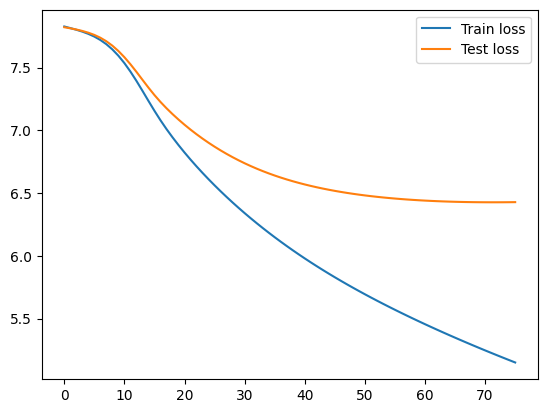

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.show()